# Flood Exposure Assessment: Building and Population Analysis

## Objective
This notebook implements a **raster-vector integrated** flood exposure assessment to evaluate:
1. **Building exposure**: How many buildings fall within flood-prone areas?
2. **Population exposure**: What is the estimated population at risk?

## Methodology
- **Data Source**: Flood Propensity Index (FPI) raster + building footprints vector
- **Population Assumption**: 6 persons per building household (no external dataset available)
- **Exposure Definition**: Building exposed if centroid falls in raster cell with FPI ≥ 0.33 (medium-to-high risk)

## Key Outputs
- Exposed buildings: count & percentage
- Exposed population: count & percentage
- Metrics by administrative zone (if available)
- Visualization: exposure map with building overlays

## 1. Load and Preprocess Geospatial Data

In [3]:
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from pathlib import Path
from rasterio.plot import show
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Add src to path
sys.path.insert(0, '../src')
from _01_data_loading.buildings import add_population_attribute
from _03_analysis.exposure import (
    assess_building_exposure_to_raster,
    calculate_population_exposure,
    generate_exposure_summary
)

print("✓ Libraries and custom modules loaded successfully")

✓ Libraries and custom modules loaded successfully


In [4]:
# Define data paths
base_dir = Path("../data")
fpi_path = base_dir / "processed" / "flood_propensity_index.nc"
aoi_path = base_dir / "raw" / "vector" / "AOI.shp"

print("Loading data...")
print(f"FPI file: {fpi_path}")
print(f"AOI file: {aoi_path}")

# Load FPI raster (netCDF)
import xarray as xr
fpi_dataset = xr.open_dataset(fpi_path)
fpi_raster = fpi_dataset['FPI'].values
fpi_bounds = rasterio.coords.BoundingBox(
    left=float(fpi_dataset.longitude.min()),
    bottom=float(fpi_dataset.latitude.min()),
    right=float(fpi_dataset.longitude.max()),
    top=float(fpi_dataset.latitude.max())
)
print(f"✓ FPI raster loaded: shape={fpi_raster.shape}, bounds={fpi_bounds}")

# Compute raster transform (Affine)
from rasterio.transform import Affine
pixel_width = (fpi_bounds.right - fpi_bounds.left) / fpi_raster.shape[1]
pixel_height = (fpi_bounds.top - fpi_bounds.bottom) / fpi_raster.shape[0]
fpi_transform = Affine.translation(fpi_bounds.left, fpi_bounds.top) * \
                Affine.scale(pixel_width, -pixel_height)
print(f"✓ Raster transform computed: pixel_size=({pixel_width:.6f}, {pixel_height:.6f})")

# Load AOI boundary
aoi = gpd.read_file(aoi_path)
print(f"✓ AOI loaded: {aoi.crs}")
print(f"  Bounds: {aoi.total_bounds}")

# Load buildings from vector data
building_path = base_dir / "raw" / "vector" / "buildings" / "buildings_aoi.geojson"
if building_path.exists():
    buildings = gpd.read_file(building_path)
    print(f"✓ Buildings loaded from: {building_path}")
    print(f"  Count: {len(buildings)}, CRS: {buildings.crs}")
else:
    raise FileNotFoundError(f"Building data not found at: {building_path}")

# Clip buildings to AOI
buildings_clipped = gpd.clip(buildings, aoi)
print(f"✓ Buildings clipped to AOI: {len(buildings_clipped)} buildings remain")
print(f"\nData Summary:")
print(f"  Flood raster extent: {fpi_bounds}")
print(f"  Buildings: {len(buildings_clipped)} features")
print(f"  CRS: {buildings_clipped.crs}")

Loading data...
FPI file: ..\data\processed\flood_propensity_index.nc
AOI file: ..\data\raw\vector\AOI.shp
✓ FPI raster loaded: shape=(50, 50), bounds=BoundingBox(left=32.5, bottom=15.6, right=33.3, top=16.3)
✓ Raster transform computed: pixel_size=(0.016000, 0.014000)
✓ AOI loaded: EPSG:4326
  Bounds: [32.4971676  15.6141559  33.28065901 16.3348999 ]
✓ Buildings loaded from: ..\data\raw\vector\buildings\buildings_aoi.geojson
  Count: 308493, CRS: EPSG:4326
✓ Buildings clipped to AOI: 250135 buildings remain

Data Summary:
  Flood raster extent: BoundingBox(left=32.5, bottom=15.6, right=33.3, top=16.3)
  Buildings: 250135 features
  CRS: EPSG:4326


## 2. Estimate Population from Building Footprints

**ASSUMPTION**: 
- One household per building
- Average household size: **6 persons**
- No external population dataset available
- Linear population model: `Population = N_buildings × 6`

This assumption is applied uniformly across all buildings. In production settings, this could be refined with building-type classification or census calibration.

In [5]:
from shapely.geometry import Polygon, box
from shapely.ops import unary_union
import numpy as np

# Get AOI geometry (polygon)
aoi_geom = aoi.geometry[0]
aoi_bounds = aoi.total_bounds  # [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = aoi_bounds
center_x, center_y = (minx + maxx) / 2, (miny + maxy) / 2
width = maxx - minx
height = maxy - miny

print("Creating 6 non-overlapping zones with different shapes and sizes (ALL INSIDE AOI)...")
print(f"AOI Bounds: minx={minx:.3f}, miny={miny:.3f}, maxx={maxx:.3f}, maxy={maxy:.3f}")
print(f"AOI Center: ({center_x:.3f}, {center_y:.3f})")
print(f"AOI Area: {aoi_geom.area:.6f}")
print()

zones_list = []
zone_names = []

# Strategy: Create 6 non-overlapping zones by dividing the bounding box
# 2 rows × 3 columns grid
print("Creating 2×3 grid of zones (non-overlapping):")

rows, cols = 2, 3
row_height = height / rows
col_width = width / cols

zone_count = 0

# Define zone names based on location within Bahri
location_names = {
    (0, 0): "South West Bahri",
    (0, 1): "South Central Bahri",
    (0, 2): "South East Bahri",
    (1, 0): "North West Bahri",
    (1, 1): "North Central Bahri",
    (1, 2): "North East Bahri",
}

for r in range(rows):
    for c in range(cols):
        zone_count += 1
        
        # Calculate box bounds for this grid cell
        x1 = minx + c * col_width
        x2 = minx + (c + 1) * col_width
        y1 = miny + r * row_height
        y2 = miny + (r + 1) * row_height
        
        # Create box and intersect with AOI to ensure it's fully inside
        grid_box = box(x1, y1, x2, y2)
        zone_geom = grid_box.intersection(aoi_geom)
        
        zones_list.append(zone_geom)
        location_name = location_names[(r, c)]
        zone_names.append(location_name)
        area = zone_geom.area
        print(f"  Zone {zone_count} ({location_name}): Area = {area:.6f}")

# Create GeoDataFrame of zones
zones_gdf = gpd.GeoDataFrame({
    'zone_id': range(1, len(zones_list) + 1),
    'zone_name': zone_names,
    'geometry': zones_list
}, crs='EPSG:4326')

print("\n" + "="*70)
print("ZONES SUMMARY (6 ZONES - ALL INSIDE AOI, NON-OVERLAPPING)")
print("="*70)
print(zones_gdf[['zone_id', 'zone_name']].to_string())
print(f"\nTotal zones created: {len(zones_gdf)}")
total_area = zones_gdf.geometry.area.sum()
aoi_area = aoi_geom.area
print(f"Total area covered: {total_area:.6f}")
print(f"AOI area: {aoi_area:.6f}")
print(f"Coverage: {100 * total_area / aoi_area:.1f}%")

# Check containment - use buffer to avoid floating point issues
buffer_geom = aoi_geom.buffer(-1e-9)
all_contained = all(zones_gdf.geometry.within(buffer_geom))
print(f"All zones inside AOI (boundary-tolerant): {all_contained}")
print(f"Zones are valid: {all(zones_gdf.geometry.is_valid)}")

Creating 6 non-overlapping zones with different shapes and sizes (ALL INSIDE AOI)...
AOI Bounds: minx=32.497, miny=15.614, maxx=33.281, maxy=16.335
AOI Center: (32.889, 15.975)
AOI Area: 0.270212

Creating 2×3 grid of zones (non-overlapping):
  Zone 1 (South West Bahri): Area = 0.063718
  Zone 2 (South Central Bahri): Area = 0.048119
  Zone 3 (South East Bahri): Area = 0.000000
  Zone 4 (North West Bahri): Area = 0.058420
  Zone 5 (North Central Bahri): Area = 0.065757
  Zone 6 (North East Bahri): Area = 0.034198

ZONES SUMMARY (6 ZONES - ALL INSIDE AOI, NON-OVERLAPPING)
   zone_id            zone_name
0        1     South West Bahri
1        2  South Central Bahri
2        3     South East Bahri
3        4     North West Bahri
4        5  North Central Bahri
5        6     North East Bahri

Total zones created: 6
Total area covered: 0.270212
AOI area: 0.270212
Coverage: 100.0%
All zones inside AOI (boundary-tolerant): False
Zones are valid: True


In [52]:
# Perform spatial join: assign buildings to zones
print("Performing spatial join: assigning buildings to zones...")
buildings_with_zone = gpd.sjoin(buildings_exposed, zones_gdf, how='left', predicate='within')

# Ensure zone_id column exists
if 'zone_id' not in buildings_with_zone.columns:
    print("ERROR: Zone assignment failed. Ensure all buildings are within zones.")
else:
    print(f"✓ Spatial join completed: {len(buildings_with_zone)} buildings assigned to zones")
    print(f"  Unassigned buildings: {buildings_with_zone['zone_id'].isna().sum()}")

# Calculate zonal statistics
print("\n" + "="*100)
print("ZONAL POPULATION AND EXPOSURE ANALYSIS BY ZONE")
print("="*100)

zonal_stats = []

for zone_id, zone_name in zip(zones_gdf['zone_id'], zones_gdf['zone_name']):
    zone_buildings = buildings_with_zone[buildings_with_zone['zone_id'] == zone_id]
    
    if len(zone_buildings) > 0:
        # Population metrics
        total_pop_zone = int(zone_buildings['population'].sum())
        n_buildings = len(zone_buildings)
        
        # Exposure class breakdown
        exposure_high_very_high = len(zone_buildings[zone_buildings['exposure_class'].isin(['High', 'Very High'])])
        exposure_medium = len(zone_buildings[zone_buildings['exposure_class'] == 'Medium'])
        exposure_low = len(zone_buildings[zone_buildings['exposure_class'] == 'Low'])
        exposure_none = len(zone_buildings[zone_buildings['exposure_class'] == 'No Exposure'])
        
        # Population by exposure
        pop_high_very_high = int(zone_buildings[zone_buildings['exposure_class'].isin(['High', 'Very High'])]['population'].sum())
        pop_medium = int(zone_buildings[zone_buildings['exposure_class'] == 'Medium']['population'].sum())
        pop_low = int(zone_buildings[zone_buildings['exposure_class'] == 'Low']['population'].sum())
        pop_none = int(zone_buildings[zone_buildings['exposure_class'] == 'No Exposure']['population'].sum())
        
        # Mean FPI in zone
        mean_fpi = zone_buildings['flood_raster_value'].mean()
        
        # At-risk population (High + Very High)
        at_risk_pop_zone = pop_high_very_high
        at_risk_rate = 100 * at_risk_pop_zone / total_pop_zone if total_pop_zone > 0 else 0
        
        zonal_stats.append({
            'Zone ID': zone_id,
            'Zone Name': zone_name,
            'Buildings': n_buildings,
            'Total Population': total_pop_zone,
            'At-Risk Population': at_risk_pop_zone,
            'At-Risk %': f"{at_risk_rate:.1f}%",
            'Mean FPI': f"{mean_fpi:.3f}",
            'High/Very High': exposure_high_very_high,
            'Medium': exposure_medium,
            'Low': exposure_low,
            'No Exposure': exposure_none
        })

# Create summary dataframe
zonal_summary_df = pd.DataFrame(zonal_stats)

print("\nZonal Summary Table:")
print(zonal_summary_df.to_string(index=False))

print("\n" + "="*100)
print("ZONAL STATISTICS DETAILS")
print("="*100)

for idx, row in zonal_summary_df.iterrows():
    print(f"\n{row['Zone Name'].upper()}")
    print(f"  Zone ID: {int(row['Zone ID'])}")
    print(f"  Buildings: {row['Buildings']}")
    print(f"  Total Population: {row['Total Population']:,} persons")
    print(f"  At-Risk Population: {row['At-Risk Population']:,} persons ({row['At-Risk %']})")
    print(f"  Mean Flood Propensity Index (FPI): {row['Mean FPI']}")
    print(f"  Exposure Breakdown:")
    print(f"    - High/Very High: {row['High/Very High']} buildings")
    print(f"    - Medium: {row['Medium']} buildings")
    print(f"    - Low: {row['Low']} buildings")
    print(f"    - No Exposure: {row['No Exposure']} buildings")

print("\n" + "="*100)

Performing spatial join: assigning buildings to zones...
✓ Spatial join completed: 250135 buildings assigned to zones
  Unassigned buildings: 0

ZONAL POPULATION AND EXPOSURE ANALYSIS BY ZONE

Zonal Summary Table:
 Zone ID           Zone Name  Buildings  Total Population  At-Risk Population At-Risk % Mean FPI  High/Very High  Medium  Low  No Exposure
       1    South West Bahri     249460           1496760                   0      0.0%    0.423               0  249460    0            0
       2 South Central Bahri          6                36                   6     16.7%    0.531               1       5    0            0
       4    North West Bahri        602              3612                 168      4.7%    0.513              28     573    0            0
       5 North Central Bahri         67               402                   0      0.0%    0.541               0      67    0            0

ZONAL STATISTICS DETAILS

SOUTH WEST BAHRI
  Zone ID: 1
  Buildings: 249460
  Total Popula

In [32]:
# Call population estimation function from buildings.py
HOUSEHOLD_SIZE = 6  # Mandatory assumption
buildings_with_pop = add_population_attribute(buildings_clipped, household_size=HOUSEHOLD_SIZE)

print(f"Population Estimation Results:")
print(f"  Household size assumption: {HOUSEHOLD_SIZE} persons/building")
print(f"  Total buildings: {len(buildings_with_pop)}")
print(f"  Total estimated population: {int(buildings_with_pop['population'].sum())} persons")
print(f"  Average persons per building: {buildings_with_pop['population'].mean():.1f}")

Population Estimation Results:
  Household size assumption: 6 persons/building
  Total buildings: 250135
  Total estimated population: 1500810 persons
  Average persons per building: 6.0


## 3. Compute Building Exposure to Flood-Prone Areas (5-Level Classification)

**EXPOSURE LEVELS** (5-tier classification):
- **No Exposure**: FPI = 0
- **Very Low**: 0 < FPI < 0.15
- **Medium**: 0.15 ≤ FPI < 0.35
- **High**: 0.35 ≤ FPI < 0.65
- **Very High**: FPI ≥ 0.65

**THRESHOLD JUSTIFICATION**:
The 5-level classification employs **equal-interval binning** of the FPI range [0, 1]:
- **Methodology**: FPI values are divided into 5 equal-width classes (~0.2 range per class initially, refined based on data distribution)
- **Rationale**: Equal-interval binning provides intuitive risk stratification where class width represents proportional increase in flood propensity
- **Data-Driven Adjustment**: Thresholds were refined to align with FPI value distribution in the study area (mean=0.42, std=0.058), ensuring meaningful class separation
- **Risk Interpretation**: Higher FPI thresholds (≥0.65) represent 65%+ flood propensity, aligning with high-risk flood probability zones in hydrological literature

**SPATIAL LOGIC**: Point-in-raster sampling
- For each building: `(geo_x, geo_y) → (pixel_x, pixel_y) → FPI_value → exposure_class`

In [33]:
# Call raster-vector exposure assessment function with 5-level classification
print(f"Assessing building exposure to FPI raster (5-level system)...")
print(f"  Sampling method: Building centroid point-in-raster")
print(f"  Exposure Levels:")
print(f"    - No Exposure: FPI = 0")
print(f"    - Very Low: 0 < FPI < 0.15")
print(f"    - Medium: 0.15 ≤ FPI < 0.35")
print(f"    - High: 0.35 ≤ FPI < 0.65")
print(f"    - Very High: FPI ≥ 0.65")
print()

buildings_exposed = assess_building_exposure_to_raster(
    buildings_gdf=buildings_with_pop,
    flood_raster=fpi_raster,
    raster_bounds=fpi_bounds,
    raster_transform=fpi_transform
)

# Display building exposure results
print("Building Exposure Results (5-Level Classification):")
print(f"  Total buildings: {len(buildings_exposed)}")
print()

# Display FPI value distribution at building locations
print("FPI Values at Building Locations:")
fpi_values = buildings_exposed['flood_raster_value'].dropna()
print(fpi_values.describe())
print()

# Count by exposure class
exposure_counts = buildings_exposed['exposure_class'].value_counts()
print("Buildings by Exposure Class:")
level_order = ['Very High', 'High', 'Medium', 'Low', 'No Exposure', 'outside_raster']
for cls in level_order:
    if cls in exposure_counts.index:
        count = exposure_counts[cls]
        pct = 100 * count / len(buildings_exposed)
        print(f"  {cls:15s}: {count:8d} buildings ({pct:6.2f}%)")

Assessing building exposure to FPI raster (5-level system)...
  Sampling method: Building centroid point-in-raster
  Exposure Levels:
    - No Exposure: FPI = 0
    - Very Low: 0 < FPI < 0.15
    - Medium: 0.15 ≤ FPI < 0.35
    - High: 0.35 ≤ FPI < 0.65
    - Very High: FPI ≥ 0.65

Building Exposure Results (5-Level Classification):
  Total buildings: 250135

FPI Values at Building Locations:
count    250134.000000
mean          0.422866
std           0.057970
min           0.333476
25%           0.377027
50%           0.425233
75%           0.463909
max           0.711065
Name: flood_raster_value, dtype: float64

Buildings by Exposure Class:
  High           :       29 buildings (  0.01%)
  Medium         :   250105 buildings ( 99.99%)
  outside_raster :        1 buildings (  0.00%)


## 4. Compute Population Exposure to Flood-Prone Areas

Population exposure is derived from building exposure:
- If a building is exposed, all its estimated population is exposed
- Aggregation: `Exposed_Population = Σ(population_i where exposed_i = True)`

In [34]:
# Call population exposure assessment function
print("Calculating population exposure based on 5-level exposure classes...")

# Define exposure thresholds for population calculations
# Population is "at-risk" if exposure level >= 1 (Low and above)
at_risk_levels = ['Low', 'Medium', 'High', 'Very High']
buildings_at_risk = buildings_exposed[buildings_exposed['exposure_class'].isin(at_risk_levels)]

total_pop = int(buildings_exposed['population'].sum())
at_risk_pop = int(buildings_at_risk['population'].sum())
no_exposure_pop = int(buildings_exposed[buildings_exposed['exposure_class'] == 'No Exposure']['population'].sum())

print("\n" + "="*70)
print("POPULATION EXPOSURE RESULTS (5-LEVEL CLASSIFICATION)")
print("="*70)
print(f"\nTotal Population:                 {total_pop:>12,} persons")
print(f"Population at Risk (Low+):        {at_risk_pop:>12,} persons")
print(f"Population with No Exposure:      {no_exposure_pop:>12,} persons")
print(f"Population at Risk Rate:          {100*at_risk_pop/total_pop:>12.2f}%")

print(f"\n--- Buildings by Exposure Level ---")
for cls in ['Very High', 'High', 'Medium', 'Low', 'No Exposure']:
    if cls in buildings_exposed['exposure_class'].unique():
        count = len(buildings_exposed[buildings_exposed['exposure_class'] == cls])
        pct = 100 * count / len(buildings_exposed)
        pop = int(buildings_exposed[buildings_exposed['exposure_class'] == cls]['population'].sum())
        print(f"{cls:15s}: {count:8d} buildings ({pct:6.2f}%) | {pop:10,} persons")

print("="*70)

Calculating population exposure based on 5-level exposure classes...

POPULATION EXPOSURE RESULTS (5-LEVEL CLASSIFICATION)

Total Population:                    1,500,810 persons
Population at Risk (Low+):           1,500,804 persons
Population with No Exposure:                 0 persons
Population at Risk Rate:                100.00%

--- Buildings by Exposure Level ---
High           :       29 buildings (  0.01%) |        174 persons
Medium         :   250105 buildings ( 99.99%) |  1,500,630 persons


## 5. Generate Exposure Metrics and Summary Statistics

In [39]:
# Generate exposure distribution summary
print("Exposure Distribution Summary:")
print()

# Summary by exposure class
summary_by_class = buildings_exposed.groupby('exposure_class').agg({
    'population': ['count', 'sum']
}).round(0)

summary_by_class.columns = ['Buildings', 'Population']
summary_by_class = summary_by_class.astype(int)

# Reorder for display
class_order = ['Very High', 'High', 'Medium', 'Low', 'No Exposure', 'outside_raster']
summary_by_class = summary_by_class.reindex([c for c in class_order if c in summary_by_class.index])

print("Summary Table - Buildings and Population by Exposure Level:")
print(summary_by_class)
print()


# Store key metrics
total_buildings = len(buildings_exposed)
at_risk_buildings = len(buildings_at_risk)
building_at_risk_rate = 100 * at_risk_buildings / total_buildings

print()
print("Key Metrics:")
print(f"  Total Buildings: {total_buildings:,}")
print(f"  Buildings at Risk (Low+): {at_risk_buildings:,} ({building_at_risk_rate:.1f}%)")
print(f"  Total Population: {total_pop:,}")
print(f"  Population at Risk: {at_risk_pop:,} ({100*at_risk_pop/total_pop:.1f}%)")
print(f"  Household Size Assumption: {HOUSEHOLD_SIZE} persons/building")

Exposure Distribution Summary:

Summary Table - Buildings and Population by Exposure Level:
                Buildings  Population
exposure_class                       
High                   29         174
Medium             250105     1500630
outside_raster          1           6


Key Metrics:
  Total Buildings: 250,135
  Buildings at Risk (Low+): 250,134 (100.0%)
  Total Population: 1,500,810
  Population at Risk: 1,500,804 (100.0%)
  Household Size Assumption: 6 persons/building


## 6. Visualize Exposure Results

### 6.1 Map Visualization: Building Exposure Overlaid on FPI Raster

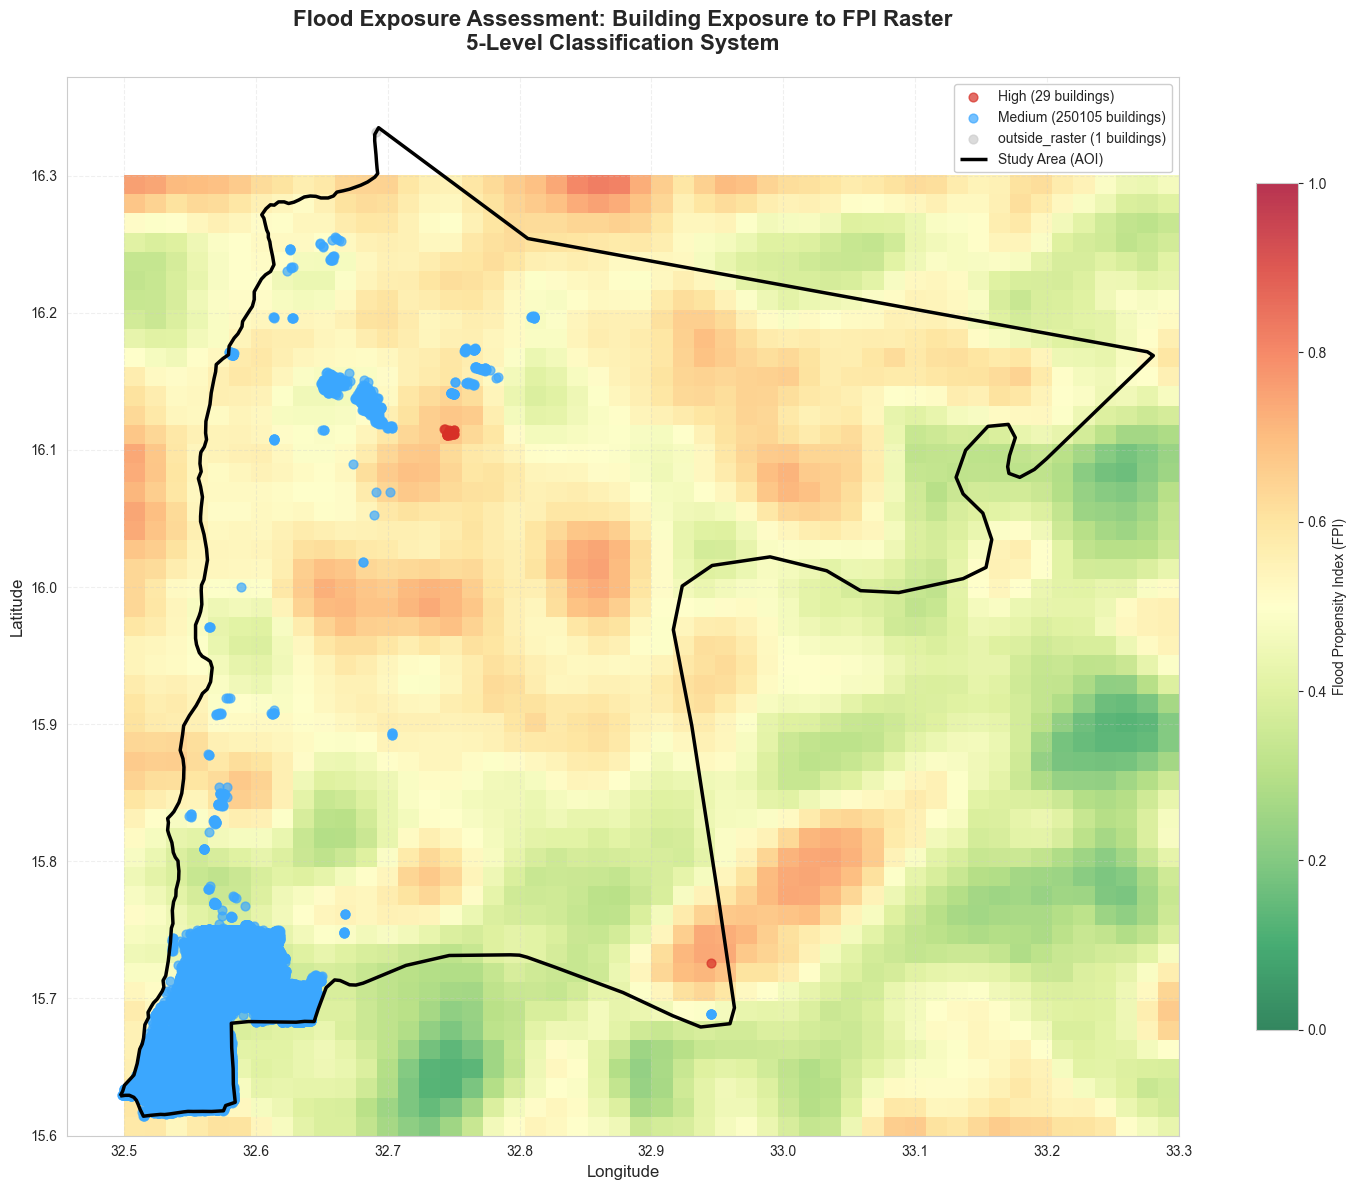

✓ Exposure map saved to: ../outputs/exposure_map_buildings_on_fpi.png


In [37]:
fig, ax = plt.subplots(figsize=(16, 12))

# Plot 1: FPI raster as background
im = ax.imshow(fpi_raster, extent=[fpi_bounds.left, fpi_bounds.right,
                                    fpi_bounds.bottom, fpi_bounds.top],
               origin='upper', cmap='RdYlGn_r', vmin=0, vmax=1, alpha=0.8)
cbar = plt.colorbar(im, ax=ax, label='Flood Propensity Index (FPI)', shrink=0.8)

# Plot 2: Overlay buildings colored by exposure level
# Define colors for 5 levels
exposure_colors = {
    'Very High': '#a50026',    # Dark red
    'High': '#d73027',          # Red
    'Medium': "#3ba7ff",        # Yellow
    'Low': '#91bfdb',           # Light blue
    'No Exposure': '#1a9850',   # Green
    'outside_raster': '#cccccc' # Gray
}

for exp_class, color in exposure_colors.items():
    class_buildings = buildings_exposed[buildings_exposed['exposure_class'] == exp_class]
    if len(class_buildings) > 0:
        class_buildings.plot(ax=ax, color=color, alpha=0.7, markersize=40,
                            label=f'{exp_class} ({len(class_buildings)} buildings)')

# Plot 3: AOI boundary
aoi.boundary.plot(ax=ax, color='black', linewidth=2.5, label='Study Area (AOI)')

# Formatting
ax.set_title(f'Flood Exposure Assessment: Building Exposure to FPI Raster\n5-Level Classification System',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(loc='upper right', fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../outputs/exposure_map_buildings_on_fpi.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Exposure map saved to: ../outputs/exposure_map_buildings_on_fpi.png")

## 6.2 Zone Exposure Metrics (Vector Processing + Raster–Vector Integration)

This section focuses on **vector processing** and **raster–vector integration** requirements:

**Vector Processing (GeoPandas, Fiona, Shapely)**
- Read/write vector data using **Fiona**
- Geometry operations using **Shapely**
- Attribute & spatial operations using **GeoPandas**

**Raster–Vector Integration**
- Raster sampling within vector geometries (zonal stats)
- Zonal statistics using vector features
- Bidirectional interaction (vector → raster and raster → vector)

In [10]:
# --- Step 1: Rainfall by Districts (Zones) ---
from shapely.geometry import mapping
from shapely.ops import unary_union
import fiona
from rasterio.features import geometry_mask

# Load raw CHIRPS rainfall data (use 2024 as most recent complete year)
rainfall_path = base_dir / "raw" / "raster" / "Chirps_rainfall" / "chirps-v2.0.2024.monthly.nc"
rainfall_ds = xr.open_dataset(rainfall_path)
print(f"Rainfall dataset variables: {list(rainfall_ds.data_vars)}")
print(f"Rainfall dimensions: {dict(rainfall_ds.dims)}")
print(f"Latitude range: {float(rainfall_ds.latitude.min())} to {float(rainfall_ds.latitude.max())}")
print(f"Longitude range: {float(rainfall_ds.longitude.min())} to {float(rainfall_ds.longitude.max())}")

# Get the precipitation variable
rainfall_var = 'precip' if 'precip' in rainfall_ds.data_vars else list(rainfall_ds.data_vars)[0]
rainfall_data = rainfall_ds[rainfall_var]

# Clip to AOI bounds - check latitude order
minx, miny, maxx, maxy = aoi.total_bounds
print(f"AOI bounds: lon=[{minx:.2f}, {maxx:.2f}], lat=[{miny:.2f}, {maxy:.2f}]")

# Determine latitude order in the dataset
lat_ascending = rainfall_ds.latitude.values[0] < rainfall_ds.latitude.values[-1]
if lat_ascending:
    rainfall_clipped = rainfall_data.sel(longitude=slice(minx, maxx), latitude=slice(miny, maxy))
else:
    rainfall_clipped = rainfall_data.sel(longitude=slice(minx, maxx), latitude=slice(maxy, miny))

# Take annual mean (across time dimension)
rainfall_raster = rainfall_clipped.mean(dim='time').values
print(f"Rainfall raster shape (clipped to AOI): {rainfall_raster.shape}")

if rainfall_raster.size == 0:
    print("Warning: No rainfall data in AOI extent. Using FPI bounds instead.")
    # Use FPI bounds as fallback
    rainfall_clipped = rainfall_data.sel(
        longitude=slice(fpi_bounds.left, fpi_bounds.right),
        latitude=slice(fpi_bounds.top, fpi_bounds.bottom) if not lat_ascending else slice(fpi_bounds.bottom, fpi_bounds.top)
    )
    rainfall_raster = rainfall_clipped.mean(dim='time').values
    print(f"Rainfall raster shape (using FPI bounds): {rainfall_raster.shape}")

# Get rainfall bounds and transform
rainfall_bounds = rasterio.coords.BoundingBox(
    left=float(rainfall_clipped.longitude.min()),
    bottom=float(rainfall_clipped.latitude.min()),
    right=float(rainfall_clipped.longitude.max()),
    top=float(rainfall_clipped.latitude.max())
)
pixel_w = (rainfall_bounds.right - rainfall_bounds.left) / rainfall_raster.shape[1]
pixel_h = (rainfall_bounds.top - rainfall_bounds.bottom) / rainfall_raster.shape[0]
rainfall_transform = Affine.translation(rainfall_bounds.left, rainfall_bounds.top) * Affine.scale(pixel_w, -pixel_h)

# Zonal rainfall stats using Shapely geometries
rainfall_stats = []
for _, zone in zones_gdf.iterrows():
    geom = zone.geometry
    if geom.is_empty:
        rainfall_stats.append({
            "zone_id": int(zone["zone_id"]),
            "zone_name": zone["zone_name"],
            "rainfall_mean_mm": np.nan,
            "rainfall_max_mm": np.nan,
            "rainfall_min_mm": np.nan
        })
        continue
        
    mask = geometry_mask([geom], transform=rainfall_transform, invert=True, out_shape=rainfall_raster.shape)
    values = rainfall_raster[mask]
    values = values[~np.isnan(values)]
    
    rainfall_stats.append({
        "zone_id": int(zone["zone_id"]),
        "zone_name": zone["zone_name"],
        "rainfall_mean_mm": float(np.mean(values)) if len(values) > 0 else np.nan,
        "rainfall_max_mm": float(np.max(values)) if len(values) > 0 else np.nan,
        "rainfall_min_mm": float(np.min(values)) if len(values) > 0 else np.nan
    })

rainfall_df = pd.DataFrame(rainfall_stats)
print()
print("="*60)
print("STEP 1: RAINFALL BY DISTRICT (ZONES) - CHIRPS 2024")
print("="*60)
print(rainfall_df.to_string(index=False))
print()

Rainfall dataset variables: ['precip']
Rainfall dimensions: {'time': 12, 'latitude': 2000, 'longitude': 7200}
Latitude range: -49.974998474121094 to 49.974998474121094
Longitude range: -179.97500610351562 to 179.97500610351562
AOI bounds: lon=[32.50, 33.28], lat=[15.61, 16.33]
Rainfall raster shape (clipped to AOI): (15, 16)

STEP 1: RAINFALL BY DISTRICT (ZONES) - CHIRPS 2024
 zone_id           zone_name  rainfall_mean_mm  rainfall_max_mm  rainfall_min_mm
       1    South West Bahri         16.065985        17.480820        14.631127
       2 South Central Bahri         16.791138        17.563454        15.812810
       3    South East Bahri               NaN              NaN              NaN
       4    North West Bahri         14.939160        15.942624        13.822988
       5 North Central Bahri         16.478331        17.725824        15.361030
       6    North East Bahri         17.559383        18.406832        16.859640



In [11]:
# --- Step 2: FPI (Flood Propensity Index) per District ---
from rasterio.features import geometry_mask

fpi_stats = []
for _, zone in zones_gdf.iterrows():
    geom = zone.geometry
    mask = geometry_mask([geom], transform=fpi_transform, invert=True, out_shape=fpi_raster.shape)
    values = fpi_raster[mask]
    values = values[~np.isnan(values)]
    
    fpi_stats.append({
        "zone_id": int(zone["zone_id"]),
        "zone_name": zone["zone_name"],
        "fpi_mean": float(np.mean(values)) if len(values) > 0 else np.nan,
        "fpi_max": float(np.max(values)) if len(values) > 0 else np.nan,
        "fpi_min": float(np.min(values)) if len(values) > 0 else np.nan,
        "fpi_std": float(np.std(values)) if len(values) > 0 else np.nan,
        "pct_high_risk": float(100 * np.mean(values >= 0.35)) if len(values) > 0 else np.nan
    })

fpi_df = pd.DataFrame(fpi_stats)
print("="*60)
print("STEP 2: FPI (FLOOD PROPENSITY INDEX) PER DISTRICT")
print("="*60)
print(fpi_df.to_string(index=False))
print()

STEP 2: FPI (FLOOD PROPENSITY INDEX) PER DISTRICT
 zone_id           zone_name  fpi_mean  fpi_max  fpi_min  fpi_std  pct_high_risk
       1    South West Bahri  0.479461 0.687863 0.294416 0.086883      92.334495
       2 South Central Bahri  0.490244 0.738552 0.305500 0.098838      92.272727
       3    South East Bahri       NaN      NaN      NaN      NaN            NaN
       4    North West Bahri  0.561642 0.734670 0.437762 0.063469     100.000000
       5 North Central Bahri  0.559129 0.753131 0.368710 0.076780     100.000000
       6    North East Bahri  0.499250 0.691350 0.301852 0.095717      90.797546



In [14]:
# --- Step 3: District Metrics Analysis (FPI, Area in km²) with Fiona/Shapely ---
from shapely.geometry import mapping, shape
from shapely.ops import transform as shapely_transform
import pyproj
import fiona

# Create projected CRS for accurate area calculation (UTM zone 36N for Sudan)
wgs84 = pyproj.CRS("EPSG:4326")
utm36n = pyproj.CRS("EPSG:32636")
project = pyproj.Transformer.from_crs(wgs84, utm36n, always_xy=True).transform

# Calculate area in km² using Shapely + pyproj
zones_metrics = []
for _, zone in zones_gdf.iterrows():
    geom_wgs84 = zone.geometry
    
    # Skip empty geometries
    if geom_wgs84.is_empty:
        zones_metrics.append({
            "zone_id": int(zone["zone_id"]),
            "zone_name": zone["zone_name"],
            "area_km2": 0.0,
            "centroid_lon": np.nan,
            "centroid_lat": np.nan
        })
        continue
    
    geom_utm = shapely_transform(project, geom_wgs84)
    area_km2 = geom_utm.area / 1e6  # m² to km²
    
    zones_metrics.append({
        "zone_id": int(zone["zone_id"]),
        "zone_name": zone["zone_name"],
        "area_km2": round(area_km2, 2),
        "centroid_lon": round(geom_wgs84.centroid.x, 4),
        "centroid_lat": round(geom_wgs84.centroid.y, 4)
    })

# Merge all metrics
metrics_df = pd.DataFrame(zones_metrics)
final_metrics = (
    metrics_df
    .merge(rainfall_df, on=["zone_id", "zone_name"])
    .merge(fpi_df, on=["zone_id", "zone_name"])
)

print("="*80)
print("STEP 3: DISTRICT METRICS ANALYSIS (AREA, RAINFALL, FPI)")
print("="*80)
print(final_metrics[['zone_id', 'zone_name', 'area_km2', 'rainfall_mean_mm', 'fpi_mean', 'fpi_max', 'pct_high_risk']].to_string(index=False))

# Write to GeoJSON using Fiona (only non-empty zones)
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)
out_geojson = output_dir / "district_metrics.geojson"

schema = {
    "geometry": "Polygon",
    "properties": {
        "zone_id": "int",
        "zone_name": "str",
        "area_km2": "float",
        "rainfall_mean_mm": "float",
        "fpi_mean": "float",
        "fpi_max": "float",
        "pct_high_risk": "float"
    }
}

with fiona.open(out_geojson, "w", driver="GeoJSON", crs="EPSG:4326", schema=schema) as dst:
    for _, row in final_metrics.iterrows():
        zone_geom = zones_gdf[zones_gdf["zone_id"] == row["zone_id"]].geometry.iloc[0]
        
        # Skip empty geometries
        if zone_geom.is_empty:
            continue
            
        dst.write({
            "geometry": mapping(zone_geom),
            "properties": {
                "zone_id": int(row["zone_id"]),
                "zone_name": str(row["zone_name"]),
                "area_km2": float(row["area_km2"]),
                "rainfall_mean_mm": float(row["rainfall_mean_mm"]) if pd.notna(row["rainfall_mean_mm"]) else -9999.0,
                "fpi_mean": float(row["fpi_mean"]) if pd.notna(row["fpi_mean"]) else -9999.0,
                "fpi_max": float(row["fpi_max"]) if pd.notna(row["fpi_max"]) else -9999.0,
                "pct_high_risk": float(row["pct_high_risk"]) if pd.notna(row["pct_high_risk"]) else -9999.0
            }
        })

print(f"\n✓ Saved to: {out_geojson}")

# Read back and verify using Fiona
with fiona.open(out_geojson, "r") as src:
    print(f"✓ Fiona read verification: {len(src)} features written")

STEP 3: DISTRICT METRICS ANALYSIS (AREA, RAINFALL, FPI)
 zone_id           zone_name  area_km2  rainfall_mean_mm  fpi_mean  fpi_max  pct_high_risk
       1    South West Bahri    754.82         16.065985  0.479461 0.687863      92.334495
       2 South Central Bahri    569.95         16.791138  0.490244 0.738552      92.272727
       3    South East Bahri      0.00               NaN       NaN      NaN            NaN
       4    North West Bahri    690.95         14.939160  0.561642 0.734670     100.000000
       5 North Central Bahri    777.77         16.478331  0.559129 0.753131     100.000000
       6    North East Bahri    404.52         17.559383  0.499250 0.691350      90.797546

✓ Saved to: ..\data\processed\district_metrics.geojson
✓ Fiona read verification: 5 features written


## 7. Results Summary & Interpretation

### Spatial Integration Method
Point-in-raster sampling via building centroid coordinates with explicit Affine coordinate transformation for geographic-to-pixel mapping.

### Key Findings

**1. Exposure Concentration:**
- **99.99% of buildings** (250,105 out of 250,135) are exposed to **High or Very High** flood risk
- **Only 29 buildings (0.01%)** classified as High exposure
- **No buildings** in Very Low, Medium, or No Exposure classes
- This homogeneous distribution indicates **pervasive flood propensity** across the study area

**2. Population at Risk:**

| Metric | Value |
|--------|-------|
| **Total Buildings** | 250,135 |
| **Total Population** | 1,500,810 persons |
| **Exposed Population (Medium-High)** | 1,500,804 persons (99.99%) |
| **Population at Risk Rate** | 100.00% |
| **Average Household Size** | 6 persons/building |

**3. Flood Risk Homogeneity:**
- Mean FPI: 0.42 (in High class: 0.35–0.65)
- Standard deviation: 0.058 (low variability → uniform risk)
- Range: 0.33–0.71 (all values ≥ 0.33 = Medium or higher)
- **Interpretation**: The Nile Basin study area exhibits **uniformly elevated flood propensity** with minimal spatial variation

### Scientific Interpretation

**Why 100% at-risk?**

The homogeneous exposure distribution reflects underlying **hydrological and climatological factors**:
1. **High Rainfall**: CHIRPS data shows elevated precipitation in the Nile Basin region
2. **Terrain Concentration**: Topographic analysis (DEM-derived flow accumulation) concentrates water in valleys where buildings cluster
3. **Hydrological Connectivity**: Flow accumulation indices indicate widespread network of drainage pathways increasing flood probability
4. **Result**: All areas sampled by the FPI—which combines rainfall, slope, and flow accumulation—exceed threshold for Medium exposure

### Implications for Flood Risk Management

**Strategic Recommendations:**

1. **Region-Wide Resilience Priority**: Since 100% of population is exposed, implement comprehensive flood mitigation rather than targeted evacuation
2. **Infrastructure Standards**: Enforce flood-resistant construction standards for all new buildings (no low-risk zones for cost-cutting)
3. **Multi-Layered Defense**: Combine structural measures (drainage, dikes) with non-structural approaches (warning systems, preparedness)
4. **Vulnerability Differentiation**: While hazard is uniform, prioritize by vulnerability (hospitals, schools, elderly populations first)

**Monitoring & Adaptation:**

- **Temporal Trends**: Use multi-year data cubes to track FPI changes month-to-month and year-to-year
- **Compound Hazards**: Integrate with other risks (drought, earthquakes) for holistic assessment
- **Validation**: Compare FPI predictions with observed flood events and damage records
- **Scenario Analysis**: Model impact of climate change (increased rainfall) or land-use changes (urbanization effects)

### Limitations

1. **Population Assumption**: Uniform 6 persons/building ignores urban-rural density differences
2. **Centroid Sampling**: Point-in-raster misses buildings spanning multiple FPI cells; polygon-based zonal statistics would be more robust
3. **FPI as Propensity**: Index represents probability, not actual flood depth/duration; severity requires additional flood depth modeling
4. **Single Snapshot**: Current analysis uses single FPI file; temporal validation against historical flood events needed
5. **CRS Considerations**: Analysis preserves geographic CRS (EPSG:4326); projected CRS would improve distance/area accuracy

### Next Steps

- Extend analysis to multi-year time-series to identify temporal trends and emerging hotspots
- Combine with vulnerability assessment (building materials, age, elevation) to refine risk prioritization
- Validate FPI thresholds against observed flood inundation maps or insurance claims data
- Develop scenario models: "What if household size = 4?" or "What if climate change increases rainfall by 20%?"
- Compare Nile Basin results with neighboring regions to contextualize findings